# **Imports**

In [1]:
# Common
import os 
import keras
import numpy as np 
from glob import glob
import tensorflow as tf

# Images 
import cv2 as cv
from keras.preprocessing.image import img_to_array

# Visualization 
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D,Conv2DTranspose, Reshape, InputLayer

# **Image Data**

In [2]:
%%time 

source_image_path = '../input/xray-bone-shadow-supression/augmented/augmented/source/'
target_image_path = '../input/xray-bone-shadow-supression/augmented/augmented/target/'

# Get Images
source_image_names = sorted(glob(source_image_path + "*.png"))
target_image_names = sorted(glob(target_image_path + "*.png"))

CPU times: user 25.1 ms, sys: 6.01 ms, total: 31.1 ms
Wall time: 95.5 ms


In [3]:
source_image_names[:10]

['../input/xray-bone-shadow-supression/augmented/augmented/source/0_0.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_1.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_10.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_100.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_101.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_102.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_103.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_104.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_105.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/source/0_106.png']

In [4]:
target_image_names[:10]

['../input/xray-bone-shadow-supression/augmented/augmented/target/0_0.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_1.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_10.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_100.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_101.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_102.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_103.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_104.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_105.png',
 '../input/xray-bone-shadow-supression/augmented/augmented/target/0_106.png']

Just wanted to make sure that the **Source Images** and the respective **Target images** get loaded correctly in the same order.

In [5]:
%%time
SIZE = 256

source_images = []
target_images = []

for img_path in source_image_names:
    img = cv.imread(img_path)
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_CUBIC)
    img = img_to_array(img)
    img = img.astype('float')/255.
    source_images.append(img)

for img_path in target_image_names:
    img = cv.imread(img_path)
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_CUBIC)
    img = img_to_array(img)
    img = img.astype('float')/255.
    target_images.append(img)

source_images = np.array(source_images)
target_images = np.array(target_images)

CPU times: user 2min 18s, sys: 58.2 s, total: 3min 16s
Wall time: 3min 59s


In [6]:
image_shape = source_images.shape[-3:]
image_shape

(256, 256, 3)

You may wonder why I am not splitting the data into **training or testing set**. Well, the reason behind that is I'm going to make the auto encoder learn under **human supervision**. That means it will be producing the images and I will be checking those images. If those **reconstructions** are not up to the point according to me. I will be upgrading the auto encoder. Instead of using a validation data set for it. One one more reason is that the total number of images is very low.

# **Visualize**

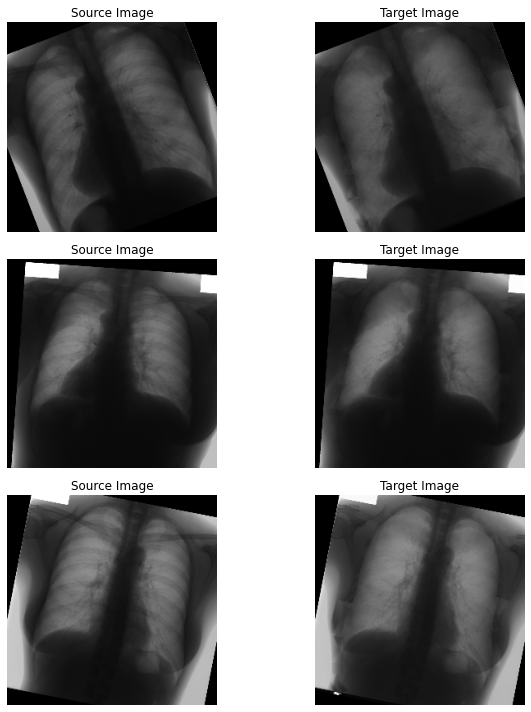

In [7]:
plt.figure(figsize=(10,10))
for i in range(1,7):
    plt.subplot(3,2,i)
    if i%2!=0:
        rand_id = np.random.randint(len(source_images))
        plt.imshow(source_images[rand_id])
        plt.title('Source Image')
    elif i%2==0:
        plt.imshow(target_images[rand_id])
        plt.title('Target Image')
    plt.axis('off')
plt.tight_layout()
plt.show()

# **AutoEncoder**

In [8]:
class EncoderLayerBlock(keras.layers.Layer):
    
    def __init__(self,filters):
        super(EncoderLayerBlock, self).__init__()
        self.filters = filters
        self.conv = Conv2D(filters,3,padding='same',activation='relu')
        self.bn = BatchNormalization()
        self.pool = MaxPool2D()
    
    def call(self, X):
        '''Takes the Input Image and pass it through the layers'''
        x = self.conv(X)
        x = self.bn(x)
        x = self.pool(x)
        
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "Filters":self.filters}

In [9]:
class ShowReconstruction(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        rand_id = np.random.randint(len(source_images))
        source_image = source_images[rand_id][np.newaxis,...]
        reconstructed = self.model.predict(source_image)
        real_image = target_images[rand_id]
        
        plt.subplot(1,3,1)
        plt.imshow(source_image[0])
        plt.title("Source Image")
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(reconstructed[0])
        plt.title("Produced Image")
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(real_image)
        plt.title("Real Image")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig("Reconstruction_Epoch_{}".format(epoch))
        plt.show()

In [10]:
autoencoder = Sequential([
    
    # Encoder
    InputLayer(image_shape), # image_shape is now (256, 256, 3)
    EncoderLayerBlock(32),
    EncoderLayerBlock(64),
    EncoderLayerBlock(128),
    
    # Latent Representation (Output is now 16x16x512)
    EncoderLayerBlock(512),
    
    # Decoder
    # 💥 CHANGE 'valid' to 'same' for stable 2x upsampling
    Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
    
    # The rest remain 'same'
    Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    
    Reshape(image_shape) # This will correctly reshape to (256, 256, 3)
])

In [11]:
autoencoder.compile(
    loss='binary_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
autoencoder.fit(
    source_images, target_images,
    epochs=25,
    callbacks=[ShowReconstruction()]
)
model_save_path = '/kaggle/working/bone_suppression_autoencoder.keras'

# Save the entire model (architecture, weights, optimizer state, etc.)
# This automatically handles the custom layer if get_config() is defined (which yours is).
autoencoder.save(model_save_path)

Epoch 1/25
  5/128 [>.............................] - ETA: 7:50 - loss: 0.6643 - accuracy: 0.4011

* $Round$ $1$ $(20 Epochs) :$ The model is able to reconstruct the **image patterns** very clearly and even **remove the shadows**, but there is still a bit of information that is lost, so we will train it for another 20 epochs.

* $Round$ $2$ $(20 Epochs) :$ Great, now the model seems to work even with different contrast and brightness levels. That is awesome, but still the nerve informations are lost. But overall the model is great.


---
* $Round$ $3$ $(50 Epochs) :$ You can just keep the model with the two rounds, but I'm going to train it again with 50 epochs so that I can see What is the peak performance of the model?

In [ ]:
autoencoder.fit(
    source_images, target_images,
    epochs=20,
    callbacks=[ShowReconstruction()]
)

The model seems to perform a little bit better, but you can go with the previous model. If you have any suggestions, please let me know in the comments.

---
$Problem :$

* The model seems to forget some of the spatial information, that is the clarity of the image.

---
$Positive Points :$

* The model seems to be robust and can work with any rotation or any light level.
* The model is able to reconstruct almost all the images perfectly.

---
**Thanks !! Let me know your suggestions.**